In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau , ModelCheckpoint
from keras.applications.mobilenet import MobileNet ,preprocess_input

In [3]:
import zipfile
import os
# Install the Kaggle library
!pip install kaggle

# Import necessary modules
from google.colab import files

# Upload the API key file (kaggle.json) that you downloaded
uploaded = files.upload()

# Move the uploaded file to ~/.kaggle/
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle datasets download -d simranvolunesia/pest-dataset


# Specify the path to your zip file
zip_file = '/content/pest-dataset.zip'  # Replace with your actual zip file path

# Specify the directory where you want to extract the contents
extract_dir = '/content'

# Create a ZipFile object
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extract_dir)

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/simranvolunesia/pest-dataset
License(s): CC0-1.0
 94% 65.0M/69.5M [00:00<00:00, 89.0MB/s]
100% 69.5M/69.5M [00:00<00:00, 104MB/s] 


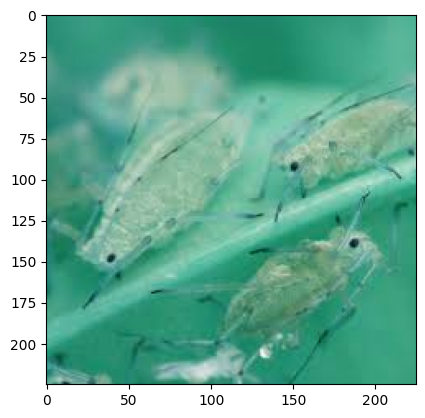

In [5]:
img=cv2.imread('/content/pest/train/aphids/jpg_0 - Copy (2).jpg')
plt.imshow(img)
plt.show()


In [6]:
img=np.array(img)
img.shape

(225, 225, 3)

In [8]:
train_dir='/content/pest/train/'
test_dir='/content/pest/train/'



training=tf.keras.preprocessing.image.ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(train_dir,batch_size=16,target_size=(224,224),subset="training")

validing=tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.05
).flow_from_directory(train_dir,batch_size=16,target_size=(224,224),subset='validation',shuffle=True)

testing=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
).flow_from_directory(test_dir,batch_size=16,target_size=(224,224),shuffle=True)


Found 2565 images belonging to 9 classes.
Found 135 images belonging to 9 classes.
Found 2700 images belonging to 9 classes.


In [9]:
mobilenet=MobileNet(include_top=False,weights='imagenet',input_shape=(224,224,3))

17225924/17225924 [==============================] - 0s 0us/step


In [26]:
optimizer=Adam(lr=0.01,beta_1=0.9,beta_2=0.99)

In [27]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_acc',verbose=2,factor=0.5,min_lr=0.001)
callback=[EarlyStop , Reduce_LR]
#model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
#callback=[EarlyStop , Reduce_LR,model_check]

In [28]:
mobilenet.trainable=False

In [29]:
model=Sequential([
    mobilenet,
    MaxPooling2D(3,2),
    Flatten(),
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dense(1024,activation='relu'),
    BatchNormalization(),
    Dense(512,activation='relu'),
    BatchNormalization(),
    Dense(9,activation='softmax')
])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 1024)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               1179776   
                                                                 
 batch_normalization_6 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                      

In [31]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=["accuracy"])

In [32]:
history=model.fit(training,validation_data=validing,epochs=50,batch_size=16,
                  steps_per_epoch=len(training) // 16,validation_steps=len(validing) // 8,
                  callbacks=callback, verbose=2)

Epoch 1/50


10/10 - 17s - loss: 2.2277 - accuracy: 0.3250 - val_loss: 9.4068 - val_accuracy: 0.1250 - lr: 0.0010 - 17s/epoch - 2s/step
Epoch 2/50


10/10 - 11s - loss: 1.8043 - accuracy: 0.5375 - val_loss: 6.2023 - val_accuracy: 0.3125 - lr: 0.0010 - 11s/epoch - 1s/step
Epoch 3/50


10/10 - 11s - loss: 1.5522 - accuracy: 0.5688 - val_loss: 4.2410 - val_accuracy: 0.2500 - lr: 0.0010 - 11s/epoch - 1s/step
Epoch 4/50


10/10 - 9s - loss: 1.1508 - accuracy: 0.6812 - val_loss: 4.2970 - val_accuracy: 0.1250 - lr: 0.0010 - 9s/epoch - 919ms/step
Epoch 5/50


10/10 - 11s - loss: 1.2266 - accuracy: 0.6938 - val_loss: 2.8927 - val_accuracy: 0.3750 - lr: 0.0010 - 11s/epoch - 1s/step
Epoch 6/50


10/10 - 14s - loss: 0.6292 - accuracy: 0.8062 - val_loss: 2.7919 - val_accuracy: 0.4375 - lr: 0.0010 - 14s/epoch - 1s/step
Epoch 7/50


10/10 - 12s - loss: 1.0640 - accuracy: 0.7250 - val_loss: 2.8258 - val_accuracy: 0.3125 - lr: 0.0010 - 12s/epoch - 1s/step
Epoch 8/50


10/10 - 10s - loss: 1.0660 - accuracy: 0.7125 - val_loss: 1.5423 - val_accuracy: 0.4375 - lr: 0.0010 - 10s/epoch - 954ms/step
Epoch 9/50


10/10 - 11s - loss: 0.9164 - accuracy: 0.7000 - val_loss: 1.7155 - val_accuracy: 0.4375 - lr: 0.0010 - 11s/epoch - 1s/step
Epoch 10/50


10/10 - 11s - loss: 0.7476 - accuracy: 0.7500 - val_loss: 1.2498 - val_accuracy: 0.5625 - lr: 0.0010 - 11s/epoch - 1s/step
Epoch 11/50


10/10 - 9s - loss: 0.9219 - accuracy: 0.7437 - val_loss: 2.5497 - val_accuracy: 0.2500 - lr: 0.0010 - 9s/epoch - 924ms/step
Epoch 12/50


10/10 - 10s - loss: 0.8015 - accuracy: 0.7625 - val_loss: 2.1886 - val_accuracy: 0.3125 - lr: 0.0010 - 10s/epoch - 995ms/step
Epoch 13/50


10/10 - 10s - loss: 0.7504 - accuracy: 0.7248 - val_loss: 0.9623 - val_accuracy: 0.6875 - lr: 0.0010 - 10s/epoch - 1s/step
Epoch 14/50


10/10 - 11s - loss: 0.5786 - accuracy: 0.7875 - val_loss: 0.2353 - val_accuracy: 0.8750 - lr: 0.0010 - 11s/epoch - 1s/step
Epoch 15/50


10/10 - 11s - loss: 0.5015 - accuracy: 0.8375 - val_loss: 0.5502 - val_accuracy: 0.7500 - lr: 0.0010 - 11s/epoch - 1s/step
Epoch 16/50


10/10 - 11s - loss: 0.5901 - accuracy: 0.8062 - val_loss: 1.0511 - val_accuracy: 0.5625 - lr: 0.0010 - 11s/epoch - 1s/step
Epoch 17/50


10/10 - 11s - loss: 0.6796 - accuracy: 0.8250 - val_loss: 2.5433 - val_accuracy: 0.5625 - lr: 0.0010 - 11s/epoch - 1s/step
Epoch 18/50


10/10 - 11s - loss: 0.6920 - accuracy: 0.7812 - val_loss: 0.5308 - val_accuracy: 0.6875 - lr: 0.0010 - 11s/epoch - 1s/step
Epoch 19/50


10/10 - 10s - loss: 0.6502 - accuracy: 0.8000 - val_loss: 1.0116 - val_accuracy: 0.5000 - lr: 0.0010 - 10s/epoch - 972ms/step
Epoch 20/50


10/10 - 11s - loss: 0.5159 - accuracy: 0.8000 - val_loss: 1.6954 - val_accuracy: 0.6250 - lr: 0.0010 - 11s/epoch - 1s/step
Epoch 21/50


10/10 - 11s - loss: 0.6595 - accuracy: 0.7875 - val_loss: 1.3922 - val_accuracy: 0.6250 - lr: 0.0010 - 11s/epoch - 1s/step
Epoch 22/50


10/10 - 9s - loss: 0.3804 - accuracy: 0.8562 - val_loss: 1.5838 - val_accuracy: 0.6250 - lr: 0.0010 - 9s/epoch - 940ms/step
Epoch 23/50


10/10 - 10s - loss: 0.4581 - accuracy: 0.8438 - val_loss: 1.2833 - val_accuracy: 0.6250 - lr: 0.0010 - 10s/epoch - 988ms/step
Epoch 24/50


10/10 - 13s - loss: 0.4515 - accuracy: 0.8188 - val_loss: 0.2865 - val_accuracy: 0.9375 - lr: 0.0010 - 13s/epoch - 1s/step


In [33]:
loss , acc = model.evaluate(testing)

169/169 [==============================] - 117s 691ms/step - loss: 0.8401 - accuracy: 0.7707


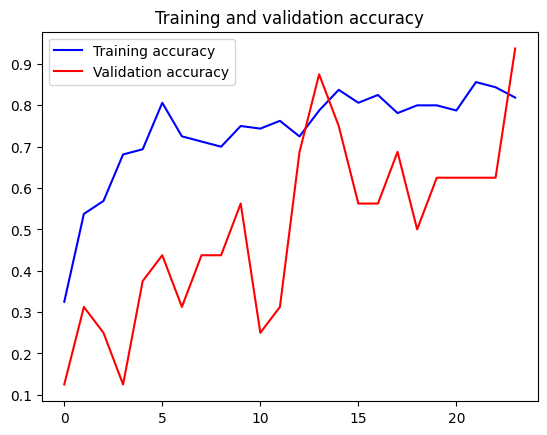

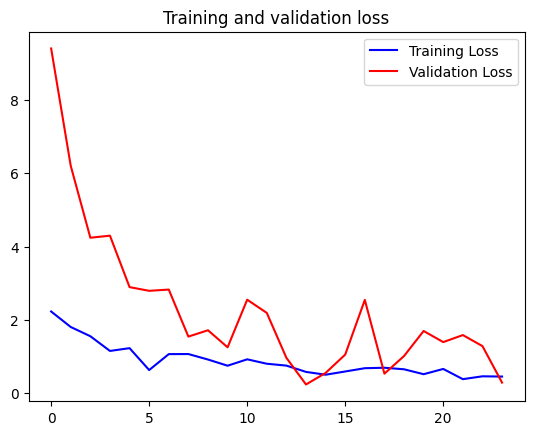

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
model.save('pest_model.h5')

In [36]:
from keras.models import load_model
model = load_model('pest_model.h5')

In [39]:
# Load an image from the test set
img_path = '/content/pest/test/beetle/jpg_1.jpg' # Replace with an actual image path
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = preprocess_input(img_array)  # Preprocess the image
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make a prediction
predictions = model.predict(img_array)

# Get the class with the highest probability
predicted_class = np.argmax(predictions[0])

# Print the predicted class
print(predicted_class)

1/1 [==============================] - 0s 63ms/step
2


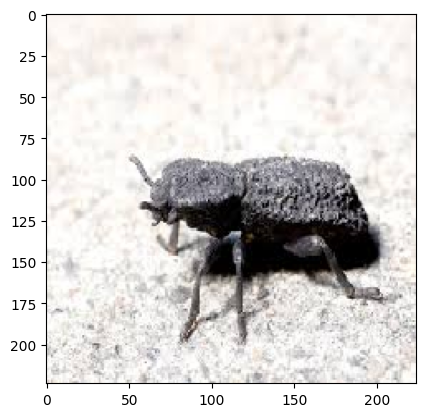

In [40]:
# Load and display the image
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 101ms/step
3


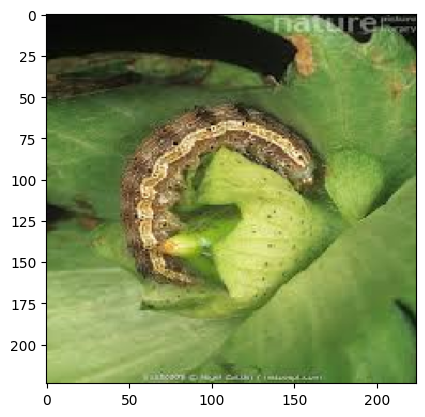

In [41]:
# Load an image from the test set
img_path = '/content/pest/test/bollworm/jpg_0.jpg' # Replace with an actual image path
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = preprocess_input(img_array)  # Preprocess the image
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make a prediction
predictions = model.predict(img_array)

# Get the class with the highest probability
predicted_class = np.argmax(predictions[0])

# Print the predicted class
print(predicted_class)

# Load and display the image
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()